In [2]:
# Base packages
from torch.utils.data import Dataset
import torch
from torch.utils.data import DataLoader

# Defined packages
from inputs import RandomPattern, noise_input
from neuralBehaviors import *
from synapseBehaviors import *
from metrics import draw_weights

# PyMonnTorch and CoNeX
from pymonntorch import NeuronGroup, SynapseGroup, NeuronDimension, EventRecorder, Recorder

from conex import Neocortex, InputLayer, Synapsis, prioritize_behaviors, CorticalColumn
from conex.behaviors.synapses import SynapseInit, WeightInitializer, LateralDendriticInput, SimpleDendriticInput, WeightNormalization
from conex.behaviors.synapses.learning import SimpleSTDP
from conex.behaviors.neurons.axon import NeuronAxon
from conex.behaviors.neurons.specs import SpikeTrace, Fire, KWTA
from conex.behaviors.neurons.dendrite import SimpleDendriteStructure, SimpleDendriteComputation
from conex.behaviors.neurons.neuron_types.lif_neurons import LIF, ELIF
from conex.behaviors.neurons import ActivityBaseHomeostasis, VoltageBaseHomeostasis
from conex.behaviors.network.time_resolution import TimeResolution

COUNTS = 5
LEN = 3
ITERS = 1000

SIZE = COUNTS * LEN
TIME = 30
NORM = 15
USE_LI = True
USE_KWTA = True
USE_VH = False # voltage based homeostasis
USE_AH = True # activity based homeostasis

patterns = []
pats = [
    [1, 1, 0],
    [1, 1, 1],
    [0, 0, 1],
    [0, 1, 1],
    [1, 0, 0],
]
for i in range(COUNTS):
    p =torch.zeros(COUNTS * LEN)
    p[i * LEN: (i+1) * LEN] = torch.tensor(pats[i])
    patterns.append(p)


dataset = RandomPattern(
    patterns=patterns,
    period=20,
)


net = Neocortex(dt=0.1)

input_layer = NeuronGroup(size=SIZE, net=net, behavior={
    160: ResetIBehavior(),
    170: InputBehavior(dataset, isForceSpike=True),
    # 175: InputBehavior(noise_input, mean=0, std=0.01),
    # 260: LIFBehavior(func='base', R=10),
    # 340: FireBehavior(),
    360: SpikeTrace(tau_s=0.5),
    380: NeuronAxon(),
    500: EventRecorder(variables=['spikes']),
    
})


conex_out_behaviors = [
        SimpleDendriteStructure(), # 220
        SimpleDendriteComputation(), # 240
        SpikeTrace(tau_s=0.5), # 360
        NeuronAxon(), # 380
        
    ]
if USE_AH:
    conex_out_behaviors.append(ActivityBaseHomeostasis(activity_rate=1, window_size=3, updating_rate=1.0))
if USE_VH:
    conex_out_behaviors.append(VoltageBaseHomeostasis(max_ta=-30, min_ta=-75))
all_out_behs = {**prioritize_behaviors(conex_out_behaviors),
    260: LIFBehavior(func='base', R=100),
    340: FireBehavior(),
    341: Recorder(variables=['v']), # right after Fire
    500: EventRecorder(variables=['spikes']),
    }
if USE_LI:
    all_out_behs[350] = LateralInhibition(alpha=50)
if USE_KWTA:
    all_out_behs[300] = KWTABehavior(k=1)

out_ng = NeuronGroup(net=net, size=COUNTS, tag='out', behavior=all_out_behs)
synapsis_input_out = SynapseGroup(net=net, src=input_layer, dst=out_ng, behavior={
                                    **prioritize_behaviors(
                                      [
                                        SynapseInit(), # 2
                                        WeightInitializer(mode='random', weight_shape=(COUNTS * LEN, COUNTS), scale=1 + NORM // SIZE), # 3
                                        SimpleDendriticInput(), # 180
                                        SimpleSTDP(a_plus=10, a_minus=10), # 400
                                        WeightNormalization(norm=NORM), # 420
                                        
                                      ]),
                                      500: Recorder(variables=['weights']),}
                                    , tag="Proximal")



net.initialize(info=False)
oldW = synapsis_input_out.weights.clone()
net.simulate_iterations(ITERS, measure_block_time=False)
newW = synapsis_input_out.weights.clone()

print(f"\nDiff W = \n{newW - oldW}")

print(f"input layer spikes: {input_layer['spikes'][0].shape[0]}")
print(f"out layer spikes: {out_ng['spikes'][0].shape[0] if out_ng['spikes'] else 0}")

print(f"Weights:\n{synapsis_input_out.weights}")




Diff W = 
tensor([[ 7.4896e-01,  6.0717e-01,  2.3225e+00,  8.1969e-01, -6.7908e-02],
        [ 7.6365e-01,  5.9557e-01,  1.7139e+00,  9.6946e-01, -5.3627e-02],
        [ 2.6467e-01,  2.6270e-02,  4.2816e-01,  1.7688e-01,  3.1276e-02],
        [-1.0768e+00, -8.8424e-01, -2.4530e+00, -4.6615e-01,  1.4225e-01],
        [-9.8535e-01, -9.1022e-01, -2.2385e+00, -4.8679e-01,  2.4230e-01],
        [-1.1030e+00, -9.0286e-01, -2.0749e+00, -4.4639e-01,  1.7129e-01],
        [ 1.9601e-01,  1.5046e-02,  1.7817e-01,  1.0126e-01,  7.7902e-02],
        [ 2.6166e-01,  2.2179e-02,  3.1276e-01,  6.4312e-02,  4.9359e-02],
        [ 6.2023e-02,  2.1785e-02,  1.1578e+00, -1.1358e+00,  2.0884e-01],
        [ 3.5616e-02,  5.4698e-03,  4.7573e-01,  1.8271e-02,  1.6385e-01],
        [ 3.0768e-01,  1.7505e+00, -5.9580e-01,  7.4313e-02, -2.6178e-01],
        [ 2.0680e-01,  1.7701e+00, -3.7721e-01, -8.1078e-03, -2.4976e-01],
        [ 5.8706e-02, -2.1328e+00,  7.0050e-01,  1.1296e-01, -5.7943e-01],
        [ 2.15

Patterns:
	0:tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
	1:tensor([0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
	2:tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
	3:tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.])
	4:tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[1.2256, 1.8237, 2.0880, 0.3301, 0.2365],
        [1.3161, 0.9457, 0.2234, 1.8460, 0.4079],
        [1.6302, 1.9874, 1.3119, 1.7902, 0.3754],
        [0.6822, 2.0592, 0.2071, 1.4208, 0.4072],
        [1.2454, 0.0940, 0.8643, 1.2119, 1.6083],
        [0.5204, 0.6507, 1.3656, 1.6209, 0.7559],
        [1.2073, 1.1384, 0.5459, 1.0249, 0.9352],
        [1.6117, 1.6780, 0.9583, 0.6509, 0.5925],
        [1.3131, 1.0342, 2.2206, 0.4530, 1.2772],
        [0.2194, 0.4138, 1.4576, 0.1849, 1.9669],
        [0.7245, 0.0361, 0.2067, 1.3472, 1.5728],
        [0.1032, 1.5219, 0.8764, 0.5130, 1.7171],
        [1.6031, 0.4036, 1.295

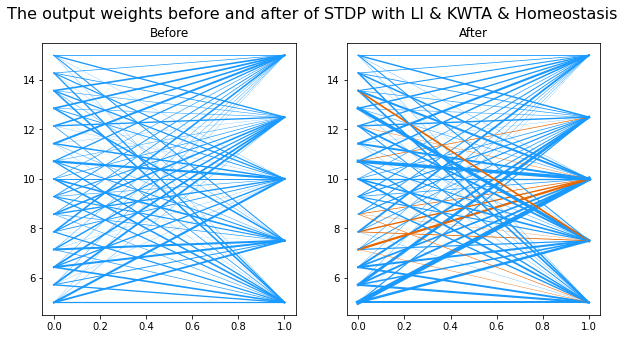

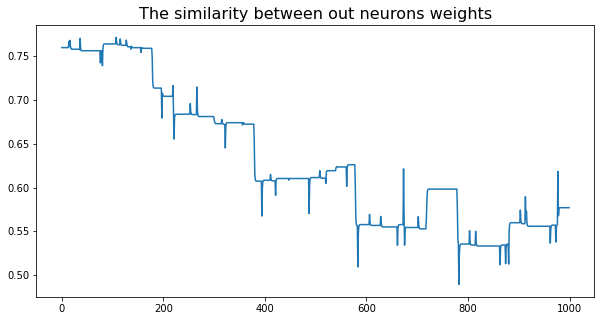

In [3]:
import matplotlib.pyplot as plt
print(f"Patterns:")
for i in range(len(dataset.pats)):
    print(f"\t{i}:{dataset.pats[i]}")


print(oldW)
print(oldW.sum(0))
print(newW)
print(newW.sum(0))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
draw_weights(weights=oldW, ax=ax[0], scale_w=1)
draw_weights(weights=newW, ax=ax[1], scale_w=1)
title = "The output weights before and after of STDP"
if USE_KWTA:
    if USE_LI:
        title += " with LI & KWTA"
        if USE_AH or USE_VH:
            title += " & Homeostasis"
    else:
        title += " with KWTA"
elif USE_LI:
    title += " with LI"

plt.suptitle(title, fontsize=16)
ax[0].set_title("Before")
ax[1].set_title("After")
plt.show()

from torch.nn.functional import cosine_similarity
w_history = synapsis_input_out['weights'][0]
sim_history = []
for iter in range(w_history.shape[0]):
    sim_history.append(cosine_similarity(w_history[iter, :, 0], w_history[iter, :, 1], dim=0))
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sim_history)
ax.set_title("The similarity between out neurons weights", fontsize=16)
plt.show()



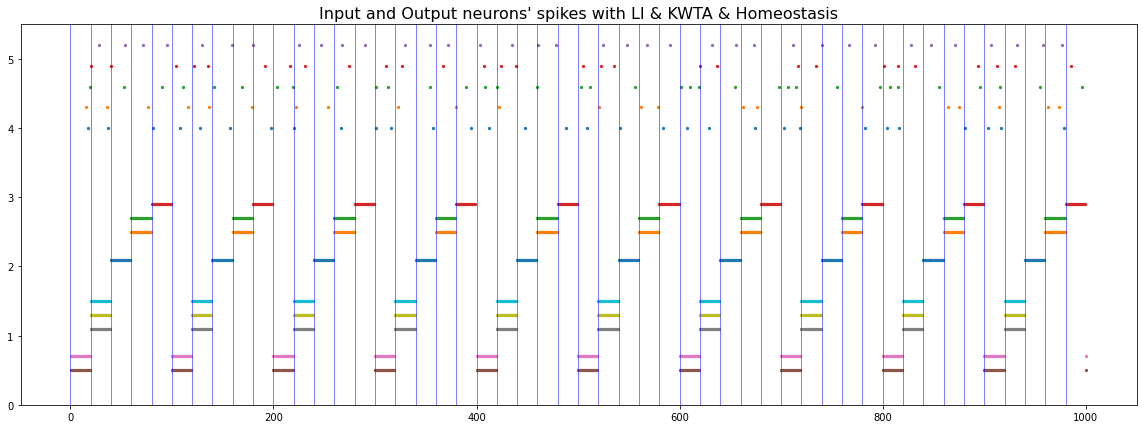

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(20, 7))

# plot output neurons
spikes = out_ng['spikes'][0]
for i in spikes[:, 1].unique():
    times = spikes[:, 1] == i
    ax.scatter(x=spikes[times][:, 0], y=4 + 0.3 * i * torch.ones(times.sum()), marker='.', s=20)

# plot input neurons
spikes = input_layer['spikes'][0]
for i in spikes[:, 1].unique():
    times = spikes[:, 1] == i
    ax.scatter(x=spikes[times][:, 0], y=0.5 + 0.2 * i * torch.ones(times.sum()), marker='.', s=20)

# add lines
for i in range(0, ITERS, 20):
    ax.axvline(i, color="blue", linewidth=0.5)
    
ax.set_ylim(0, 5.5)
title = "Input and Output neurons' spikes"
if USE_KWTA:
    if USE_LI:
        title += " with LI & KWTA"
        if USE_AH or USE_VH:
            title += " & Homeostasis"
    else:
        title += " with KWTA"
elif USE_LI:
    title += " with LI"

ax.set_title(title, fontsize=16)
plt.show()

